In [1]:
import pandas as pd
import numpy as np
import topmed_genotypes as tg
import matplotlib.pyplot as plt
import seaborn as sns
from plutils import figures
import subprocess
import tempfile

PREFIX = 'replication-of-eqtlgen-trans-eqtl.'
USE_CLUMPED = False # TODO: if use clumped, should also adjust slope if that's relevant

def distance_between_variants(variant_1, variant_2):
    if pd.isnull(variant_1) or pd.isnull(variant_2):
        return np.NaN
    variant_1_chrom, variant_1_pos = variant_1.split('_')[:2]
    variant_2_chrom, variant_2_pos = variant_2.split('_')[:2]
    if variant_1_chrom != variant_2_chrom:
        return np.NaN
    else:
        return abs(int(variant_1_pos) - int(variant_2_pos))


def pi0est(pv):
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        TMP_FILE = f.name
        for p in pv:
            f.write(f'{p}\n')
        f.close()
        cmd = ['Rscript', '-e', f'library(qvalue); tmp = read.table("{TMP_FILE}", head=F)$V1; pi0est(tmp)$pi0']
        sp = subprocess.run(cmd, capture_output=True, check=True)
    return float(sp.stdout.decode().replace('[1] ', '').rstrip())

def pi1est(pv):
    return 1 - pi0est(pv)

In [2]:
eqtlgen_significant_hg38 = pd.read_csv('/net/topmed11/working/porchard/eqtlgen-preprocessing/work/lift-and-tabix/trans-significant/results/tabixed/eqtlgen.txt.gz', sep='\t')
eqtlgen_significant_hg38['abs_z'] = eqtlgen_significant_hg38.Zscore.abs()
eqtlgen_significant_hg38 = eqtlgen_significant_hg38.sort_values('abs_z', ascending=False)
eqtlgen_top_hg38 = eqtlgen_significant_hg38.groupby('Gene').head(1).rename(columns={'Gene': 'gene_id'})
eqtlgen_top_hg38.head()

,#chrom,start,end,Pvalue,SNP,Zscore,gene_id,GeneSymbol,NrCohorts,NrSamples,FDR,BonferroniP,abs_z
1991,chr1,247876148,247876149,1.128895e-308,chr1_247876149_C_T,-72.1091,ENSG00000166086,JAM3,37,31684,0.0,6.659500e-302,72.1091
7958,chr12,56041719,56041720,1.128895e-308,chr12_56041720_G_C,60.9665,ENSG00000265688,MAFG-AS1,9,10740,0.0,6.659500e-302,60.9665
31754,chr3,56815720,56815721,1.128895e-308,chr3_56815721_T_C,57.2518,ENSG00000163736,PPBP,37,31684,0.0,6.659500e-302,57.2518
31753,chr3,56815720,56815721,1.128895e-308,chr3_56815721_T_C,51.2592,ENSG00000188677,PARVB,37,31684,0.0,6.659500e-302,51.2592
31752,chr3,56815720,56815721,1.128895e-308,chr3_56815721_T_C,50.8175,ENSG00000198478,SH3BGRL2,37,31684,0.0,6.659500e-302,50.8175


In [3]:
len(eqtlgen_top_hg38)

6298

56860
5884


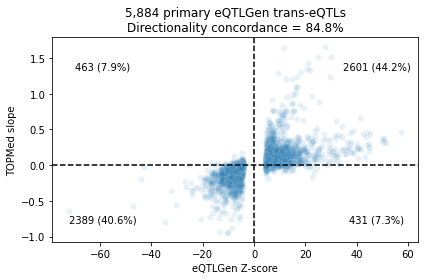

In [4]:

replicated_in_topmed = pd.read_csv('../work/replicate-trans/eqtlgen/results/replicated/results.txt', sep='\t')
print(len(replicated_in_topmed))
replicated_in_topmed = replicated_in_topmed.rename(columns={'slope': 'topmed_slope', 'p': 'topmed_p'}).merge(eqtlgen_top_hg38[['gene_id', 'SNP', 'Pvalue', 'Zscore']].rename(columns={'GeneID': 'gene_id', 'SNP': 'variant_id'}))
print(len(replicated_in_topmed))
replicated_in_topmed.head()

fig, ax = plt.subplots()

df = replicated_in_topmed
ql = figures.make_quadrant_labels(df.Zscore, df.topmed_slope)
sns.scatterplot(x='Zscore', y='topmed_slope', ax=ax, data=df, alpha=0.1)
figures.plot_quadrant_labels(ql, ax)
ax.axvline(0, ls='--', color='black')
ax.axhline(0, ls='--', color='black')
ax.set_xlabel('eQTLGen Z-score')
ax.set_ylabel('TOPMed slope')
ax.set_title('{:,} primary eQTLGen trans-eQTLs\nDirectionality concordance = {}%'.format(len(df), round(100*(np.sign(df.Zscore) == np.sign(df.topmed_slope)).mean(), 1)))

fig.tight_layout()
fig.savefig(f'{PREFIX}replication-in-topmed.png', dpi=300, facecolor='white', bbox_inches='tight')

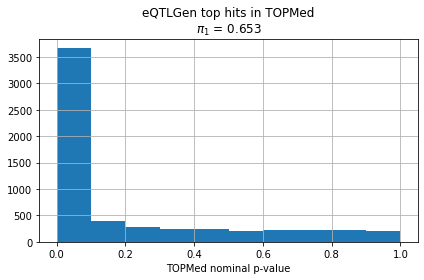

In [5]:
fig, ax = plt.subplots()

replicated_in_topmed.topmed_p.hist(ax=ax)
ax.set_title('eQTLGen top hits in TOPMed\n$\pi_1$ = {}'.format(round(pi1est(replicated_in_topmed.topmed_p.to_list()), 3)))
ax.set_xlabel('TOPMed nominal p-value')

fig.tight_layout()
fig.savefig(f'{PREFIX}replication-in-topmed.pi1.png', dpi=300, facecolor='white', bbox_inches='tight')


In [6]:
replicated_in_topmed.head()

,variant_id,gene_id,topmed_slope,topmed_p,Pvalue,Zscore
0,chr1_3063713_T_C,ENSG00000110651,-0.001458,0.942961,5.339200e-06,-4.5509
1,chr1_3774964_A_G,ENSG00000259483,0.027314,0.183800,7.925000e-06,-4.4670
2,chr1_8090578_T_C,ENSG00000132801,-0.030680,0.251933,6.731700e-06,4.5020
3,chr1_8444361_C_A,ENSG00000036448,-0.012389,0.499260,1.418000e-08,-5.6714
4,chr1_8444361_C_A,ENSG00000103479,-0.032642,0.075014,1.466500e-09,-6.0480


In [7]:
eqtlgen = pd.read_csv('/net/topmed11/working/porchard/eqtlgen-preprocessing/work/lift-and-tabix/trans/results/tabixed/eqtlgen.txt.gz', sep='\t')
eqtlgen.head()

,#chrom,start,end,Pvalue,SNP,Zscore,Gene,GeneSymbol,NrCohorts,NrSamples,FDR,BonferroniP
0,chr1,1312113,1312114,0.000125,chr1_1312114_T_C,-3.8358,ENSG00000120533,ENY2,11,10248,0.269975,1.0
1,chr1,1312113,1312114,0.000388,chr1_1312114_T_C,3.5478,ENSG00000162337,LRP5,21,13151,0.450067,1.0
2,chr1,1312113,1312114,0.000426,chr1_1312114_T_C,-3.5232,ENSG00000186777,ZNF732,9,4665,0.466094,1.0
3,chr1,1312113,1312114,0.000429,chr1_1312114_T_C,3.5214,ENSG00000230457,PA2G4P4,9,4665,0.467159,1.0
4,chr1,1312113,1312114,0.000468,chr1_1312114_T_C,-3.4982,ENSG00000153879,CEBPG,23,18440,0.481805,1.0


In [8]:
eqtlgen['abs_z'] = eqtlgen.Zscore.abs()
eqtlgen = eqtlgen.sort_values('abs_z', ascending=False)
eqtlgen.head()

,#chrom,start,end,Pvalue,SNP,Zscore,Gene,GeneSymbol,NrCohorts,NrSamples,FDR,BonferroniP,abs_z
44442172,chr12,56042144,56042145,3.271700e-310,chr12_56042145_C_G,-74.5151,ENSG00000196656,AC004057.1,13,5502,0.0,6.659500e-302,74.5151
18771031,chr1,247876148,247876149,3.271700e-310,chr1_247876149_C_T,-72.1091,ENSG00000166086,JAM3,37,31684,0.0,6.659500e-302,72.1091
168431059,chr6,33579059,33579060,3.271700e-310,chr6_33579060_T_C,71.8435,ENSG00000175730,BAK1P1,13,5502,0.0,6.659500e-302,71.8435
44344646,chr12,56007300,56007301,3.271700e-310,chr12_56007301_G_A,-71.7641,ENSG00000196656,AC004057.1,12,5417,0.0,6.659500e-302,71.7641
44481683,chr12,56076840,56076841,3.271700e-310,chr12_56076841_C_T,-71.1079,ENSG00000196656,AC004057.1,13,5502,0.0,6.659500e-302,71.1079


In [9]:
topmed_trans_eqtl = pd.read_csv('../work/clump-trans-variants/clump-trans-signals.significant-trans-eqtl-clumped.tsv', sep='\t')
if USE_CLUMPED:
    topmed_trans_eqtl.variant_id = topmed_trans_eqtl.clumped_variant_id
topmed_trans_eqtl = topmed_trans_eqtl[topmed_trans_eqtl.tissue.isin(['PBMC', 'Whole_blood'])]
topmed_trans_eqtl['gene_id'] = topmed_trans_eqtl.phenotype_id.str.split('.', expand=True)[0]
topmed_trans_eqtl.head()

,variant_id,phenotype_id,pval,b,b_se,r2,af,gene_mappability,gene_crossmaps_to_gene_near_variant,biotype,...,beta_shape2,true_df,pval_true_df,pval_perm,pval_beta,pval_beta_no_zero,qvalue,tissue,clumped_variant_id,gene_id
0,chr7_50330658_C_T,ENSG00000000938.13,3.503050e-25,-0.234596,0.022533,0.016690,0.235203,0.999762,False,protein_coding,...,9.795177e+05,6086.276059,4.468785e-24,0.00005,3.457262e-18,3.457262e-18,1.392881e-16,Whole_blood,chr7_50342615_A_G,ENSG00000000938
1,chr1_156302480_C_T,ENSG00000002330.13,1.027770e-13,0.134956,0.018106,0.008625,0.500775,0.999556,False,protein_coding,...,1.008630e+06,6081.962583,3.926652e-13,0.00005,3.664337e-07,3.664337e-07,5.779733e-06,Whole_blood,chr1_156344836_A_G,ENSG00000002330
2,chr6_144036619_C_A,ENSG00000004059.11,1.984040e-17,0.331091,0.038865,0.011237,0.055934,1.000000,False,protein_coding,...,9.587406e+05,6060.399614,1.281332e-16,0.00005,9.188711e-11,9.188711e-11,2.100000e-09,Whole_blood,chr6_144036619_C_A,ENSG00000004059
3,chr6_122440739_T_C,ENSG00000004478.8,1.034670e-10,0.126184,0.019495,0.006518,0.706539,0.960425,False,protein_coding,...,1.105596e+06,6130.610651,2.431723e-10,0.00025,2.609707e-04,2.609707e-04,2.773133e-03,Whole_blood,chr6_122440739_T_C,ENSG00000004478
4,chr22_46290431_C_G,ENSG00000004799.8,7.740950e-13,0.207077,0.028839,0.008009,0.107530,1.000000,False,protein_coding,...,9.587406e+05,6060.399614,2.939505e-12,0.00005,2.389651e-06,2.389651e-06,3.403684e-05,Whole_blood,chr22_46290431_C_G,ENSG00000004799


In [10]:
all_variants = set(topmed_trans_eqtl.variant_id).union(set(eqtlgen.SNP))

In [11]:
all_variants_df = pd.DataFrame(list(all_variants), columns=['variant_id'])
all_variants_df[['chrom', 'pos']] = all_variants_df.variant_id.str.split('_', expand=True)[[0, 1]]
all_variants_df.head()

,variant_id,chrom,pos
0,chr1_200912467_G_A,chr1,200912467
1,chr21_43067294_T_C,chr21,43067294
2,chr12_65970729_T_C,chr12,65970729
3,chr5_77184008_T_C,chr5,77184008
4,chr8_56296687_A_G,chr8,56296687


In [12]:
# TODO: use EUR samples only?
aac = pd.concat(
    [tg.get_alt_allele_counts(vcf_path=f'../data/genotypes/vcfs-updated-ids-pass-filter/{chrom}.vcf.gz', variants=df.variant_id.unique()) for chrom, df in all_variants_df.groupby('chrom')]
)
aac.head()

,NWD100109,NWD100234,NWD100395,NWD100423,NWD100436,NWD100609,NWD100677,NWD100822,NWD100922,NWD100934,...,NWD999190,NWD999225,NWD999256,NWD999266,NWD999349,NWD999373,NWD999460,NWD999511,NWD999589,NWD999620
chr1_200912467_G_A,0,0,1,0,0,0,2,0,0,0,...,0,0,1,0,0,0,0,1,0,0
chr1_196704863_A_C,2,0,1,1,1,1,1,2,1,2,...,1,2,0,1,1,1,1,0,0,2
chr1_100775337_T_C,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,1,1,1,0,1,1
chr1_2137733_C_T,1,0,1,1,1,0,1,1,1,1,...,1,0,1,0,0,0,0,1,2,0
chr1_17348042_C_A,0,2,0,2,1,1,2,1,1,0,...,0,2,1,0,0,0,1,1,0,1


In [13]:
ld_matrix = tg.alt_allele_counts_matrix_to_r2_matrix(aac)
ld_matrix.head()

,chr1_200912467_G_A,chr1_196704863_A_C,chr1_100775337_T_C,chr1_2137733_C_T,chr1_17348042_C_A,chr1_158668470_G_A,chr1_68169707_T_C,chr1_67228519_A_G,chr1_22141722_C_T,chr1_39570256_G_T,...,chrX_100163844_T_C,chrX_95798706_C_T,chrX_135293015_C_A,chrX_135403038_T_C,chrX_32451637_AG_A,chrX_9988166_A_G,chrX_53192077_T_TG,chrX_111054598_T_A,chrX_53203852_G_C,chrX_135293321_T_C
chr1_200912467_G_A,1.000000,0.005081,0.002528,0.000143,0.000059,0.000323,0.000343,0.000020,0.000218,0.002194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1_196704863_A_C,0.005081,1.000000,0.000727,0.000427,0.000505,0.000051,0.001187,0.000103,0.004455,0.001864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1_100775337_T_C,0.002528,0.000727,1.000000,0.001038,0.000345,0.000651,0.002132,0.001988,0.000602,0.003935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1_2137733_C_T,0.000143,0.000427,0.001038,1.000000,0.000014,0.000143,0.000019,0.002781,0.005714,0.001029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1_17348042_C_A,0.000059,0.000505,0.000345,0.000014,1.000000,0.000085,0.000042,0.000071,0.000276,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# what if we just compare top variants by chrom?
eqtlgen_top = eqtlgen.groupby('Gene').head(1).rename(columns={'Gene': 'gene_id'})
eqtlgen_top.head()

,#chrom,start,end,Pvalue,SNP,Zscore,gene_id,GeneSymbol,NrCohorts,NrSamples,FDR,BonferroniP,abs_z
44442172,chr12,56042144,56042145,3.271700e-310,chr12_56042145_C_G,-74.5151,ENSG00000196656,AC004057.1,13,5502,0.0,6.659500e-302,74.5151
18771031,chr1,247876148,247876149,3.271700e-310,chr1_247876149_C_T,-72.1091,ENSG00000166086,JAM3,37,31684,0.0,6.659500e-302,72.1091
168431059,chr6,33579059,33579060,3.271700e-310,chr6_33579060_T_C,71.8435,ENSG00000175730,BAK1P1,13,5502,0.0,6.659500e-302,71.8435
10739864,chr1,156730858,156730859,3.271700e-310,chr1_156730859_T_G,64.3149,ENSG00000227183,HDGFP1,10,4339,0.0,6.659500e-302,64.3149
164573432,chr6,32184664,32184665,3.271700e-310,chr6_32184665_A_G,63.9737,ENSG00000253570,RNF5P1,11,4805,0.0,6.659500e-302,63.9737


In [15]:
len(eqtlgen_top)

19942

In [16]:
eqtlgen.head()

,#chrom,start,end,Pvalue,SNP,Zscore,Gene,GeneSymbol,NrCohorts,NrSamples,FDR,BonferroniP,abs_z
44442172,chr12,56042144,56042145,3.271700e-310,chr12_56042145_C_G,-74.5151,ENSG00000196656,AC004057.1,13,5502,0.0,6.659500e-302,74.5151
18771031,chr1,247876148,247876149,3.271700e-310,chr1_247876149_C_T,-72.1091,ENSG00000166086,JAM3,37,31684,0.0,6.659500e-302,72.1091
168431059,chr6,33579059,33579060,3.271700e-310,chr6_33579060_T_C,71.8435,ENSG00000175730,BAK1P1,13,5502,0.0,6.659500e-302,71.8435
44344646,chr12,56007300,56007301,3.271700e-310,chr12_56007301_G_A,-71.7641,ENSG00000196656,AC004057.1,12,5417,0.0,6.659500e-302,71.7641
44481683,chr12,56076840,56076841,3.271700e-310,chr12_56076841_C_T,-71.1079,ENSG00000196656,AC004057.1,13,5502,0.0,6.659500e-302,71.1079


In [17]:
pairs = topmed_trans_eqtl[['variant_id', 'gene_id', 'tissue']].merge(eqtlgen[['Gene', 'SNP', 'Pvalue', 'FDR']].rename(columns={'Gene': 'gene_id', 'SNP': 'variant_id'}), how='left')
pairs.head()

,variant_id,gene_id,tissue,Pvalue,FDR
0,chr7_50330658_C_T,ENSG00000000938,Whole_blood,6.786500e-23,0.0
1,chr1_156302480_C_T,ENSG00000002330,Whole_blood,NaN,NaN
2,chr6_144036619_C_A,ENSG00000004059,Whole_blood,NaN,NaN
3,chr6_122440739_T_C,ENSG00000004478,Whole_blood,NaN,NaN
4,chr22_46290431_C_G,ENSG00000004799,Whole_blood,NaN,NaN


In [18]:
pairs['topmed_pair_tested_in_eqtlgen'] = pairs.Pvalue.notnull()
pairs.head()

,variant_id,gene_id,tissue,Pvalue,FDR,topmed_pair_tested_in_eqtlgen
0,chr7_50330658_C_T,ENSG00000000938,Whole_blood,6.786500e-23,0.0,True
1,chr1_156302480_C_T,ENSG00000002330,Whole_blood,NaN,NaN,False
2,chr6_144036619_C_A,ENSG00000004059,Whole_blood,NaN,NaN,False
3,chr6_122440739_T_C,ENSG00000004478,Whole_blood,NaN,NaN,False
4,chr22_46290431_C_G,ENSG00000004799,Whole_blood,NaN,NaN,False


In [19]:
print(len(pairs), len(pairs.drop_duplicates()))

1829 1829


In [20]:
topmed_trans_eqtl.tissue.value_counts()

Whole_blood    1725
PBMC            104
Name: tissue, dtype: int64

In [21]:
eqtlgen_top.gene_id.value_counts().max()

1

In [22]:
len(eqtlgen_top[eqtlgen_top.FDR<=0.05])

7861

In [23]:
eqtlgen_significant = pd.read_csv('/net/topmed11/working/porchard/eqtlgen-preprocessing/data/eqtlgen/2018-09-04-trans-eQTLsFDR0.05-CohortInfoRemoved-BonferroniAdded.txt.gz', sep='\t')
eqtlgen_transegenes = eqtlgen_significant.Gene.unique()

In [24]:
for tissue, df in topmed_trans_eqtl.groupby('tissue'):
    print(tissue, df.gene_id.isin(eqtlgen_transegenes).value_counts())

PBMC True     86
False    18
Name: gene_id, dtype: int64
Whole_blood True     1348
False     377
Name: gene_id, dtype: int64


In [25]:
# compare whole blood??
tmp = topmed_trans_eqtl[['variant_id', 'gene_id', 'tissue']].rename(columns={'variant_id': 'topmed_variant'}).merge(eqtlgen_top[['gene_id', 'SNP']].rename(columns={'SNP': 'eqtlgen_variant'}), how='left')
print(len(tmp))
tmp['topmed_variant_tested_in_eqtlgen'] = tmp.topmed_variant.isin(eqtlgen.SNP)
tmp = tmp.merge(pairs[['variant_id', 'gene_id', 'tissue', 'topmed_pair_tested_in_eqtlgen', 'FDR']].rename(columns={'variant_id': 'topmed_variant'}), how='left')
print(len(tmp))
tmp['same_lead_variant'] = tmp.topmed_variant == tmp.eqtlgen_variant
tmp['same_lead_variant_and_significant'] = (tmp.same_lead_variant) & (tmp.FDR<=0.05)
tmp['linear_distance'] = [distance_between_variants(i, j) for i, j in zip(tmp.topmed_variant, tmp.eqtlgen_variant)]
tmp['r2'] = [ld_matrix.at[i,j] if i in ld_matrix.index and j in ld_matrix.columns else np.nan for i, j in zip(tmp.topmed_variant, tmp.eqtlgen_variant)]
tmp['high_ld'] = (tmp.r2>=0.8).astype(int)
tmp.head()

1829
1829


,topmed_variant,gene_id,tissue,eqtlgen_variant,topmed_variant_tested_in_eqtlgen,topmed_pair_tested_in_eqtlgen,FDR,same_lead_variant,same_lead_variant_and_significant,linear_distance,r2,high_ld
0,chr7_50330658_C_T,ENSG00000000938,Whole_blood,chr7_50330658_C_T,True,True,0.0,True,True,0.0,1.000000,1
1,chr1_156302480_C_T,ENSG00000002330,Whole_blood,chr7_50360730_C_A,False,False,NaN,False,False,NaN,0.000000,0
2,chr6_144036619_C_A,ENSG00000004059,Whole_blood,chr7_50330658_C_T,False,False,NaN,False,False,NaN,0.000000,0
3,chr6_122440739_T_C,ENSG00000004478,Whole_blood,chr6_122398486_G_T,False,False,NaN,False,False,42253.0,0.928360,1
4,chr22_46290431_C_G,ENSG00000004799,Whole_blood,chr22_46231706_C_T,False,False,NaN,False,False,58725.0,0.395678,0


In [26]:
tmp.tissue.value_counts()

Whole_blood    1725
PBMC            104
Name: tissue, dtype: int64

In [27]:
print(tmp.groupby('tissue').high_ld.mean())
print(tmp.groupby('tissue').high_ld.value_counts())

tissue
PBMC           0.442308
Whole_blood    0.262609
Name: high_ld, dtype: float64
tissue       high_ld
PBMC         0            58
             1            46
Whole_blood  0          1272
             1           453
Name: high_ld, dtype: int64


In [28]:
print(tmp[tmp.topmed_variant_tested_in_eqtlgen].groupby('tissue').same_lead_variant.mean())
print(tmp[tmp.topmed_variant_tested_in_eqtlgen].groupby('tissue').same_lead_variant.value_counts())

tissue
PBMC           0.764706
Whole_blood    0.540230
Name: same_lead_variant, dtype: float64
tissue       same_lead_variant
PBMC         True                  39
             False                 12
Whole_blood  True                 188
             False                160
Name: same_lead_variant, dtype: int64


In [29]:
print(tmp[tmp.topmed_pair_tested_in_eqtlgen].groupby('tissue').same_lead_variant.mean())
print(tmp[tmp.topmed_pair_tested_in_eqtlgen].groupby('tissue').same_lead_variant.value_counts())

tissue
PBMC           0.829787
Whole_blood    0.571429
Name: same_lead_variant, dtype: float64
tissue       same_lead_variant
PBMC         True                  39
             False                  8
Whole_blood  True                 188
             False                141
Name: same_lead_variant, dtype: int64


In [30]:
print(tmp[tmp.topmed_pair_tested_in_eqtlgen].groupby('tissue').same_lead_variant_and_significant.mean())
print(tmp[tmp.topmed_pair_tested_in_eqtlgen].groupby('tissue').same_lead_variant_and_significant.value_counts())

tissue
PBMC           0.829787
Whole_blood    0.568389
Name: same_lead_variant_and_significant, dtype: float64
tissue       same_lead_variant_and_significant
PBMC         True                                  39
             False                                  8
Whole_blood  True                                 187
             False                                142
Name: same_lead_variant_and_significant, dtype: int64
